In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Loading Data

In [2]:
path_dataset = "/workspaces/Forcast_PM_CNX/PM2.5"
# load all files
all_files = glob.glob(path_dataset + "/*.xlsx")

In [3]:
all_files=sorted(all_files)

In [5]:
xls = pd.ExcelFile(all_files[0])
test_df = pd.read_excel(xls, 'PM2.5')

In [6]:
test_df

,Date,54T,36T,30T
0,2011-01-01 00:00:00,NaN,NaN,NaN
1,2011-01-02 00:00:00,NaN,NaN,NaN
2,2011-01-03 00:00:00,NaN,NaN,NaN
3,2011-01-04 00:00:00,NaN,NaN,NaN
4,2011-01-05 00:00:00,NaN,NaN,NaN
...,...,...,...,...
363,2011-12-30 00:00:00,NaN,22.0,26.0
364,2011-12-31 00:00:00,NaN,21.0,25.0
365,NaN,NaN,NaN,NaN
366,NaN,NaN,NaN,NaN


# Pre-processing Data

In [13]:
# Create an empty dataframe for waiting for the concatenation
merged_df = pd.DataFrame(columns=['Date', '36T'])
for file_name in all_files:
    xls = pd.ExcelFile(file_name)
    df = pd.read_excel(xls, 'PM2.5')
    
    # Drop every row following Date containing NaN
    df = df.dropna(subset=['Date'])
    # Keep only Date and 36T Column
    try:
        df = df[['Date', '36T']]
    except:
        df = df[['Date', '36T ']]
        # rename the column form '36T ' to '36T'
        df = df.rename(columns={'36T ': '36T'})
       
       
    # Convert Date to datetime, if some rows are not in the right format, drop them
    try:
        # Drop last row, then convert to datetime
        df = df[:-1]
        df['Date'] = pd.to_datetime(df['Date'])
    except:
        df['Date'] = pd.to_datetime(df['Date'])
       
    # Concatenate the dataframe
    merged_df = pd.concat([merged_df, df], axis=0)
# reset index
merged_df = merged_df.reset_index(drop=True)
merged_df

/tmp/ipykernel_20224/2935119691.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat([merged_df, df], axis=0)


,Date,36T
0,2011-01-01,NaN
1,2011-01-02,NaN
2,2011-01-03,NaN
3,2011-01-04,NaN
4,2011-01-05,NaN
...,...,...
4742,2023-12-27,28.7
4743,2023-12-28,29.8
4744,2023-12-29,23.2
4745,2023-12-30,20.2


# Manipulating Data

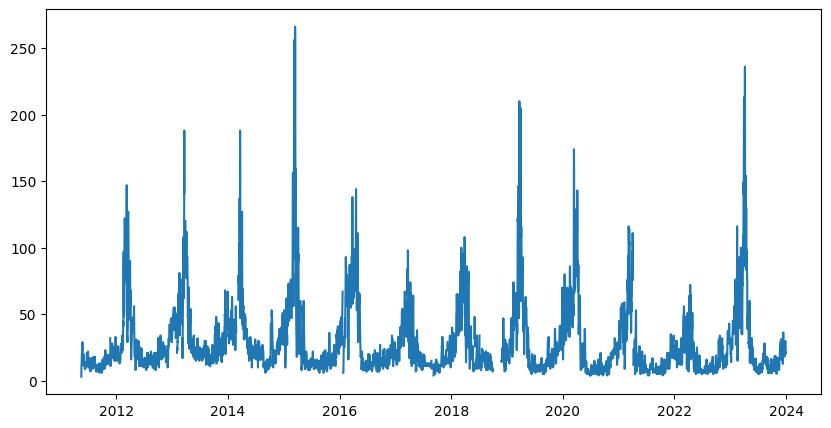

In [14]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'], merged_df['36T'])
plt.show()

<Figure size 1000x500 with 0 Axes>

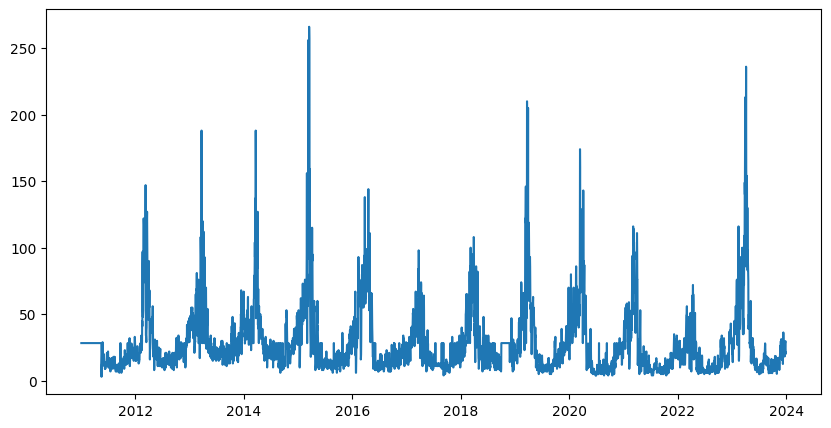

In [15]:
# Replace the NaN values by the mean of the column
mean_df_copy = merged_df.copy()
mean_df_copy['36T'] = mean_df_copy['36T'].fillna(mean_df_copy['36T'].mean())
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
plt.plot(mean_df_copy['Date'], mean_df_copy['36T'])
plt.show()

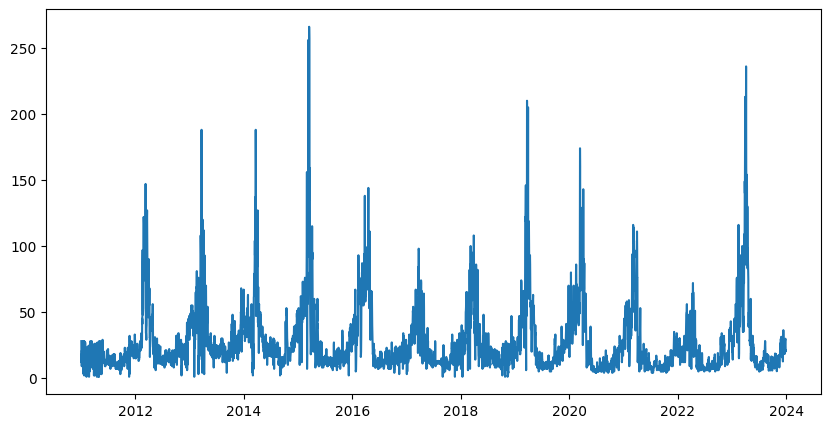

In [16]:
# Replace the NaN values by random values in the range 1 to the mean by each row
random_df_copy = merged_df.copy()
mean_value = random_df_copy['36T'].mean()
random_values = pd.Series(np.random.randint(1, mean_value + 1, size=len(random_df_copy)), index=random_df_copy.index)
random_df_copy['36T'] = random_df_copy['36T'].fillna(random_values)

plt.figure(figsize=(10, 5))
plt.plot(random_df_copy['Date'], random_df_copy['36T'])
plt.show()

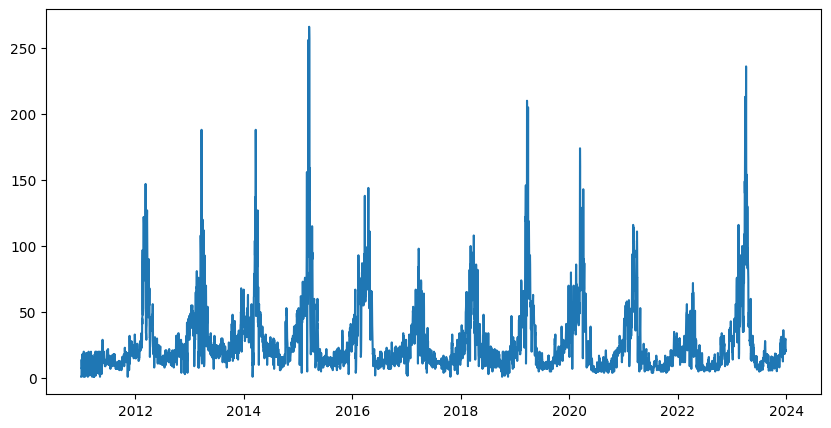

In [17]:
# Replace the NaN values with range 1 to 30
random_df_copy2 = merged_df.copy()
min_ = 1
max_ = 20
random_values = pd.Series(np.random.randint(min_, max_+1, size=len(random_df_copy2)), index=random_df_copy2.index)
random_df_copy2['36T'] = random_df_copy2['36T'].fillna(random_values)

plt.figure(figsize=(10, 5))
plt.plot(random_df_copy2['Date'], random_df_copy2['36T'])
plt.show()

# Decomposing Data

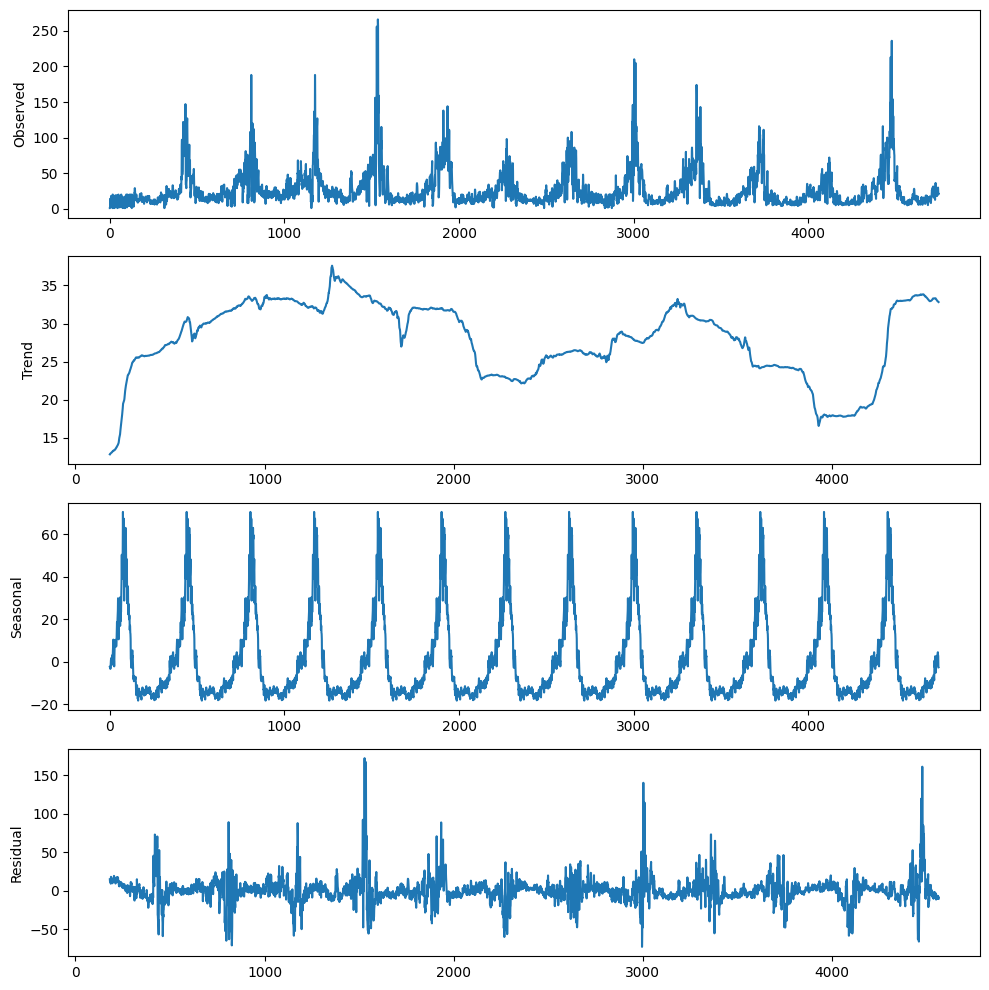

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the data
decomposed = seasonal_decompose(random_df_copy2['36T'], model='additive', period=365)
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))
decomposed.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposed.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposed.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposed.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

## Splitting Data

In [21]:
# display last rows of the dataframe
random_df_copy2.tail()

,Date,36T
4742,2023-12-27,28.7
4743,2023-12-28,29.8
4744,2023-12-29,23.2
4745,2023-12-30,20.2
4746,2023-12-31,21.1


In [22]:
# Split the data into train and test, by 2011-2021 being the train and 2022-2023 the test
train = random_df_copy2[random_df_copy2['Date'].dt.year < 2022]
test = random_df_copy2[random_df_copy2['Date'].dt.year >= 2022]

# Model Building

## ARIMA Model

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the model

model = ARIMA(train['36T'])
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
# Calculate the error
error = mean_squared_error(test['36T'], predictions)
error

767.9943536902836

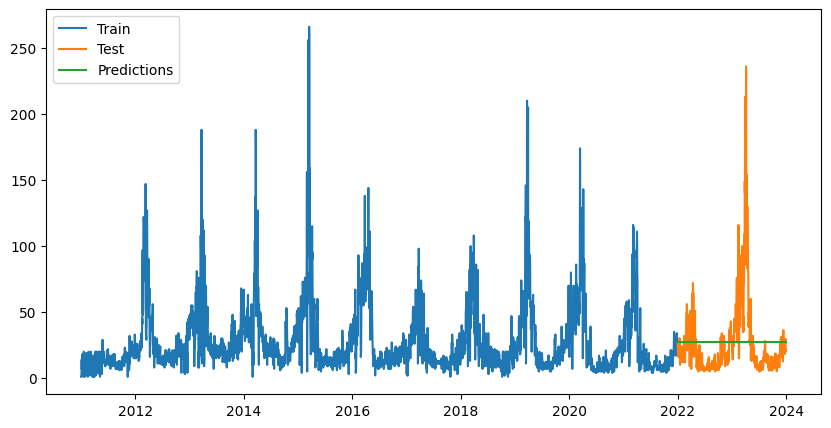

In [24]:
# predict on test then plot
plt.figure(figsize=(10,5))
plt.plot(train['Date'], train['36T'], label='Train')
plt.plot(test['Date'], test['36T'], label='Test')
plt.plot(test['Date'], predictions, label='Predictions')
plt.legend()
plt.show()

## LSTM Model

In [25]:
train.shape, test.shape

((4017, 2), (730, 2))

In [34]:
# # Set time lag for prediction
# This code work on correct x1, x2, x3, ... x30 to predict x31, x32, x33, ... x60
next_t = 30

# Training data
X_train = []
y_train = []
for i in range(len(train) - next_t):
    X_train.append(train['36T'].values[i:i+next_t])
    y_train.append(train['36T'].values[i+1:i+next_t+1])
X_train = np.array(X_train)
y_train = np.array(y_train)
 
# Testing data
X_test = []
y_test = []
for i in range(len(test) - next_t):
    X_test.append(test['36T'].values[i:i+next_t])
    y_test.append(test['36T'].values[i+1:i+next_t+1])
X_test = np.array(X_test)
y_test = np.array(y_test)

# reshape the data
X_train = X_train.reshape(-1, next_t, 1)
y_train = y_train.reshape(-1, next_t, 1)
X_test = X_test.reshape(-1, next_t, 1)
y_test = y_test.reshape(-1, next_t, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3987, 30, 1), (3987, 30, 1), (700, 30, 1), (700, 30, 1))

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(next_t, 1), return_sequences=True))
model.add(Dense(1, activation='relu'))  # Moved activation parameter inside Dense
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=1, shuffle=False, validation_data=(X_test, y_test))

Epoch 1/200


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1162.0594 - val_loss: 1210.1743
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 868.8156 - val_loss: 995.4708
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 719.7637 - val_loss: 902.9409
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 650.7787 - val_loss: 845.8996
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 605.1713 - val_loss: 793.1863
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 565.3222 - val_loss: 749.4641
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 529.7428 - val_loss: 714.0350
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 501.5997 - val_loss: 683.3663
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 476.8512 - val_loss: 655.6905
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 454.9055 - val_loss: 630.4460
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 434.7752 - val_loss: 607.4795
Epoch 12/200
63/63

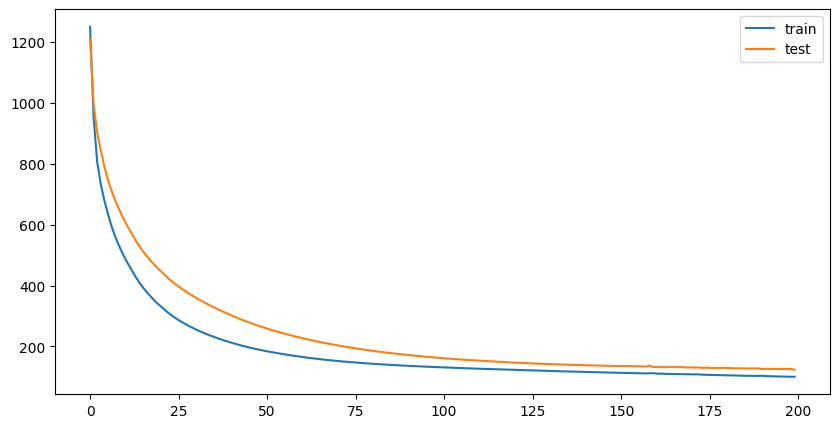

In [41]:
# display loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
X_test.shape ,y_test.shape

((700, 30, 1), (700, 30, 1))

In [55]:
# make a full prediction on the test data, then plot the result on dataframe

In [43]:
# make a prediction and evaluuate
y_pred = model.predict(X_test[-1].reshape(1, next_t, 1))
# reshape the data
y_pred = y_pred.reshape(-1, 1)
print(y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
(30, 1)


In [49]:
# Last date of the test data
last_date = test['Date'].values[-1]

# Create the next 30 days date range
next_t = 30
next_t_days = pd.date_range(last_date, periods=next_t)

# Concatenate the last 30 days and the next 30 days into a new dataframe named big_df based on random_df_copy
big_df = random_df_copy.copy()
predicted_values_df = pd.DataFrame({'Date': next_t_days, '36T': None})
big_df = pd.concat([big_df, predicted_values_df], ignore_index=True)

big_df.tail()

/tmp/ipykernel_20224/3019929442.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, predicted_values_df], ignore_index=True)


,Date,36T
4772,2024-01-25,NaN
4773,2024-01-26,NaN
4774,2024-01-27,NaN
4775,2024-01-28,NaN
4776,2024-01-29,NaN


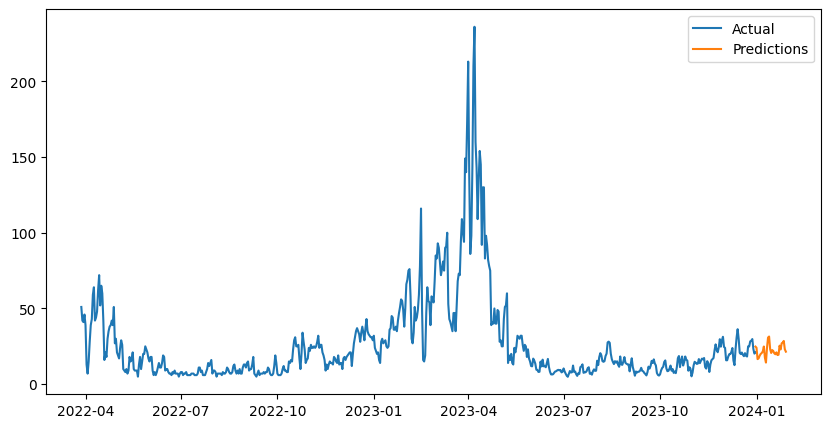

In [50]:
import datetime
# Calculate the date 2 years ago from the current date
two_years_ago = datetime.datetime.now() - datetime.timedelta(days=365*2)

# Filter the dataframe based on the date range
filtered_df = big_df[big_df['Date'] >= two_years_ago]

# Plot the filtered dataframe
plt.figure(figsize=(10,5))
plt.plot(filtered_df['Date'], filtered_df['36T'], label='Actual')
# plot on predicted values
plt.plot(next_t_days, y_pred, label='Predictions')
plt.legend()
plt.show()